In [1]:
pwd

'c:\\Users\\82438\\OneDrive - HKUST Connect\\23Fall\\MAFM6010Z_AI for Fintech\\warmup'

In [2]:
import os
for dirname, _, filenames in os.walk('./home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./home-credit-default-risk\application_test.csv
./home-credit-default-risk\application_train.csv
./home-credit-default-risk\bureau.csv
./home-credit-default-risk\bureau_balance.csv
./home-credit-default-risk\credit_card_balance.csv
./home-credit-default-risk\HomeCredit_columns_description.csv
./home-credit-default-risk\installments_payments.csv
./home-credit-default-risk\POS_CASH_balance.csv
./home-credit-default-risk\previous_application.csv
./home-credit-default-risk\sample_submission.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_columns", 200)
pd.reset_option("display.max_rows", 200)

from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import os
import torch
cpuCount = os.cpu_count()
print("CPU:", cpuCount)
print('GPU：', torch.cuda.device_count())


CPU: 8
GPU： 1


In [6]:
applytrain = pd.read_csv("./home-credit-default-risk/application_train.csv")
applytest = pd.read_csv("./home-credit-default-risk/application_test.csv")

In [7]:
features = pd.read_csv("./output/features.csv", index_col=0)

C:\Users\82438\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
features.head().T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5
...,...,...,...,...,...
ORGANIZATION_TYPE,NaN,NaN,NaN,NaN,NaN
FONDKAPREMONT_MODE,NaN,NaN,NaN,NaN,NaN
HOUSETYPE_MODE,NaN,NaN,NaN,NaN,NaN
WALLSMATERIAL_MODE,NaN,NaN,NaN,NaN,NaN


In [9]:
missing_dict = {}
for col in tqdm(features.columns):
    missing_dict[col] = features[col].isnull().sum() / features.shape[0]

100%|██████████| 769/769 [00:01<00:00, 462.92it/s]


### 数据清洗

#### delete those features whose missing rate over 90\%

In [10]:
feacols = [col for col in missing_dict.keys() if missing_dict[col] <= 0.9]
feacols.remove('SK_ID_CURR')

In [11]:
print(f'删除前的特征数量:{len(missing_dict.keys()) - 1}')
print(f'删除后的特征数量:{len(feacols)}')

删除前的特征数量:768
删除后的特征数量:753


#### 分成train和test

In [12]:
print(features.shape[0], applytrain.shape[0]+applytest.shape[0])
features = pd.merge(features, applytrain[['SK_ID_CURR', 'TARGET']], how='left', left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])
print(features.shape)

356255 356255


(356255, 770)


In [13]:
features['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [14]:
applytest.shape
## check over

(48744, 121)

In [15]:
del applytrain
del applytest

In [16]:
strcols = []
for col in tqdm(feacols):
    if features[col].dtypes not in ['int64', 'float64']:
        try:
            features[col] = pd.to_numeric(features[col])
        except Exception as e:
            print(col)
            strcols.append(col)

 86%|████████▌ | 649/753 [00:00<00:00, 6446.89it/s]

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE


100%|██████████| 753/753 [00:00<00:00, 1796.26it/s]

NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


In [17]:
feacols = [col for col in feacols if col not in strcols]

In [18]:
def replace_nm(s, str1, str2):
    for string in str1:
        s = s.replace(string, str2)
    return s
replace_nm('abc', ['a', 'b'], '_')

'__c'

In [19]:
features.rename(columns={col:replace_nm(col, ['(', ')', '.'], '_') for col in features.columns}, inplace=True)
feacols = [replace_nm(col, ['(', ')', '.'], '_') for col in feacols]

#### normalization

In [20]:
from sklearn import preprocessing 

features[feacols] = preprocessing.scale(features[feacols])

#### fillna

In [21]:
features[feacols] = features[feacols].fillna(0)

In [22]:
X = features[(features['TARGET'].isnull() == False)]
test = features[(features['TARGET'].isnull() == True)]
print(X.shape, test.shape)

(307511, 770) (48744, 770)


### choosing features

In [23]:
X['TARGET'].value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [24]:
X['TARGET'].value_counts(normalize=False)

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

#### SMOTE
计算机没资源了，本来想做但是放弃了

In [25]:
# from imblearn.over_sampling import SMOTE

# X[feacols] = X[feacols].fillna(0)
# smo = SMOTE()
# X_smo, y_smo = smo.fit_resample(X[feacols], X['TARGET'])
# y_smo.value_counts()

In [23]:
from sklearn.model_selection import train_test_split

# train:test:dev = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X[feacols], X['TARGET'], test_size=0.2, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X[feacols], X['TARGET'], test_size=0.5, random_state=42)

#### 比较一下用CPU和GPU哪个更快

In [27]:
%%time
from lightgbm import LGBMClassifier

params = {'n_estimators':500
         ,'early_stopping':100
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'n_jobs':8}

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.638056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135184
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 731
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.252398	training's l1: 0.130916	training's binary_logloss: 0.22872	valid_1's rmse: 0.252055	valid_1's l1: 0

LGBMClassifier(early_stopping=100, learning_rate=0.05, max_depth=5,
               n_estimators=500, n_jobs=8, num_leaves=11)

In [33]:
%%time
from lightgbm import LGBMClassifier

params = {'n_estimators':500
         ,'early_stopping':100
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'device':'gpu'
         ,'gpu_device_id':0
         }

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135184
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 731
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 325 dense feature groups (76.95 MB) transferred to GPU in 0.100796 secs. 1 sparse feature groups
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.4316

LGBMClassifier(device='gpu', early_stopping=100, gpu_device_id=2,
               learning_rate=0.05, max_depth=5, n_estimators=500,
               num_leaves=11)

#### find out that gpu-lightgbm is no faster than CPU

### 筛选特征

#### find features who are important

In [35]:
IM = pd.DataFrame().from_dict(dict(zip(feacols, lgb.feature_importances_)), orient='index', columns=['im']).sort_values(by=['im'], ascending=False)
IM.head(200)

,im
EXT_SOURCE_1,189
EXT_SOURCE_2,167
EXT_SOURCE_3,161
AMT_ANNUITY,116
DAYS_BIRTH,106
...,...
MEAN_bureau_DAYS_CREDIT_UPDATE_,7
MAX_previous_application_PRODUCT_COMBINATION_invsd_,7
SUM_bureau_AMT_CREDIT_SUM_LIMIT_,7
SKEW_previous_application_AMT_CREDIT_,7


In [36]:
IM.shape, IM[(IM['im'] > 0)].shape

((742, 1), (560, 1))

In [37]:
feacols2 = list(IM[(IM['im'] > 0)].index)

In [46]:
import joblib
# 保存入模变量
joblib.dump(feacols2, "./feacols2.pkl")

['./feacols2.pkl']

#### 网格搜索寻找最佳参数

In [41]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[500, 1000]
         ,'num_leaves': [5, 11]
         ,'max_depth':[5, 10]
         ,'learning_rate':[0.05]
         ,'n_jobs':[8]}

lgb = LGBMClassifier()
grid_search = GridSearchCV(lgb, params)

grid_search.fit(X_train[feacols2], y_train)

[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.302334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116256
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.090848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116248
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[L

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05], 'max_depth': [5, 10],
                         'n_estimators': [500, 1000], 'n_jobs': [8],
                         'num_leaves': [5, 11]})

In [42]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': 8, 'num_leaves': 5}
Best score:  0.919718058189229


In [25]:
import joblib
feacols2 = joblib.load("./feacols2.pkl")
len(feacols2)

560

In [26]:
from lightgbm import LGBMRegressor

params = {'learning_rate': 0.05
          ,'max_depth': 5
          ,'n_estimators': 500
          ,'n_jobs': 8
          ,'num_leaves': 5}
lgb = LGBMRegressor(**params)
lgb.fit(X_train[feacols2], y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train[feacols2], y_train), (X_test[feacols2], y_test)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.450235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 560
[LightGBM] [Info] Start training from score 0.080794


LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, n_jobs=8,
              num_leaves=5)

#### model evaluation

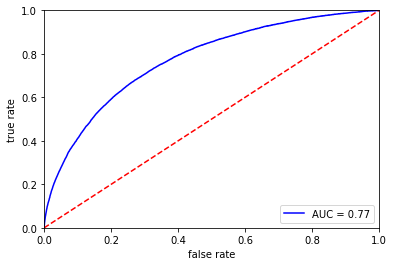

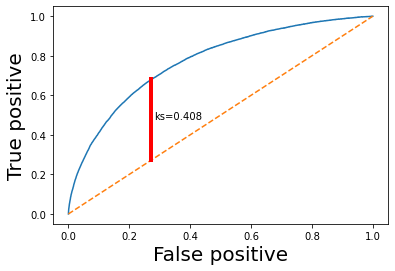

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

y_pred = lgb.predict(X_dev[feacols2])

fpr, tpr, thresholds = roc_curve(y_dev, y_pred)

#计算ROC，并绘制曲线
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('true rate')
plt.xlabel('false rate')
plt.show()
    
ks_value = max(abs(fpr-tpr))
#ROC曲线
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
#绘制KS
x = np.argwhere(abs(fpr-tpr) == ks_value)[0, 0]
plt.plot([fpr[x], fpr[x]], [fpr[x], tpr[x]], linewidth=4, color='r')
plt.text(fpr[x]+0.01,tpr[x]-0.2, 'ks='+str(format(ks_value,'0.3f')),color= 'black')
plt.xlabel('False positive', fontsize=20)
plt.ylabel('True positive', fontsize=20)
plt.show()

In [28]:
# lgb.predict(X_dev[feacols2], raw_score=False), fpr[x]
y_pred01 = (y_pred >= fpr[x]) * 1
y_pred01


array([0, 0, 0, ..., 1, 0, 0])

In [45]:
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
import seaborn as sns
print('confusion matrix:')
print(confusion_matrix(y_dev, y_pred01))
print("f1-score: {:.2f}".format(f1_score(y_dev, y_pred01)))
print("f_beta-score(beta=2): {:.2f}".format(fbeta_score(y_dev, y_pred01, beta=2)))

confusion matrix:
[[138680   2644]
 [ 10526   1906]]
f1-score: 0.22
f_beta-score(beta=2): 0.18


<AxesSubplot:ylabel='feature name'>

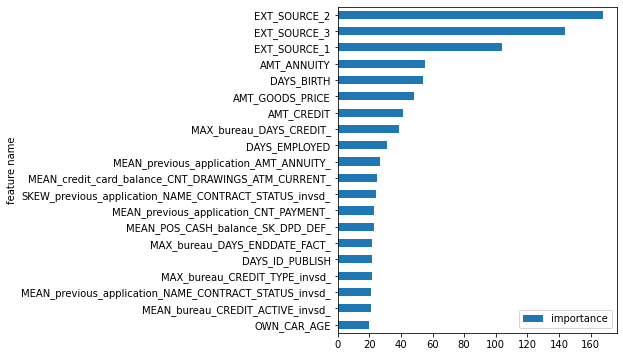

In [37]:
df = pd.DataFrame()
df['feature name'] = lgb.feature_name_
df['importance'] = lgb.feature_importances_
df = df.sort_values('importance')
df.tail(20).plot.barh(x = 'feature name',figsize=(5,6))

#### save model..

In [30]:
import joblib
joblib.dump(lgb, "./lgb.pkl")

['./lgb.pkl']

### predict


In [31]:
test['TARGET'] = (lgb.predict(test[feacols2]) >= fpr[x]) * 1

C:\Users\82438\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
test[['SK_ID_CURR', 'TARGET']].to_csv("./submission.csv", index=False, sep=',')

#### 最后的结果放入kaggle结果为0.5477